# **Klasfikasi Suara**

Pengenalan suara adalah teknologi yang memungkinkan komputer atau mesin 
untuk mengenali, memahami, dan memproses ucapan manusia sehingga dapat 
diterjemahkan menjadi perintah atau teks. Teknologi ini semakin banyak 
digunakan dalam kehidupan sehari-hari, mulai dari asisten virtual hingga 
sistem kontrol perangkat pintar.

Dalam analisis ini, saya mencoba membangun model sederhana yang mampu 
membedakan dua kata perintah dasar: **"buka"** dan **"tutup"** dan model identifikasi suara orang(speaker): **SAHL** dan **NAUFAL**. Dataset 
yang digunakan berasal dari rekaman suara sendiri.


## **1. Data Understanding & Preprocessing Awal**

### **1.1 Install Dependency yang diperlukan**

In [ ]:
pip install librosa soundfile numpy matplotlib seaborn scikit-learn pydub ffmpeg-python joblib soundfile tsfel

In [20]:
import os
from pydub import AudioSegment
import pandas as pd
import librosa
import tsfel
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score,  RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib




### **1.2 Konversi data suara dari .m4a ke .wav**

In [3]:
input_folder = "data_suara"             
output_folder = "data_suara_wav"        
os.makedirs(output_folder, exist_ok=True)

count = 0
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(".m4a"):
            src = os.path.join(root, file)
            rel = os.path.relpath(root, input_folder)
            dst_dir = os.path.join(output_folder, rel)
            os.makedirs(dst_dir, exist_ok=True)
            dst = os.path.join(dst_dir, file.replace(".m4a", ".wav"))
            if not os.path.exists(dst):
                try:
                    audio = AudioSegment.from_file(src, format="m4a")
                    audio.export(dst, format="wav")
                except Exception as e:
                    print(f"Gagal mengonversi {src}: {e}")
            count += 1

print("Total file .m4a diperiksa:", count)

Total file .m4a diperiksa: 400


### **1.3 Muat Dataset .wav dan Pahami Datanya**

In [4]:
import os
import pandas as pd

DATA_DIR = "data_suara_wav"

audio_files = []
labels = []

for label in os.listdir(DATA_DIR):
    subfolder = os.path.join(DATA_DIR, label)
    if not os.path.isdir(subfolder): continue
    for filename in os.listdir(subfolder):
        if filename.lower().endswith((".wav")):
            file_path = os.path.join(subfolder, filename)
            audio_files.append(file_path)
            labels.append(label)

df = pd.DataFrame({"file": audio_files, "label": labels})

print("Jumlah data per label:")
print(df['label'].value_counts())
df.head()

Jumlah data per label:
label
buka_naufal     100
buka_sahl       100
tutup_naufal    100
tutup_sahl      100
Name: count, dtype: int64


,file,label
0,data_suara_wav\buka_naufal\Buka-1.wav,buka_naufal
1,data_suara_wav\buka_naufal\Buka-10.wav,buka_naufal
2,data_suara_wav\buka_naufal\Buka-100.wav,buka_naufal
3,data_suara_wav\buka_naufal\Buka-11.wav,buka_naufal
4,data_suara_wav\buka_naufal\Buka-12.wav,buka_naufal


### **1.4 Deskripsi dasar suara**

In [5]:
import librosa

durations = []
sample_rates = []

for f in df['file']:
    y, sr = librosa.load(f, sr=16000, mono=True)
    durations.append(len(y)/sr)
    sample_rates.append(sr)

df["duration_sec"] = durations
df["sample_rate"] = sample_rates

df.describe()

,duration_sec,sample_rate
count,400.000000,400.0
mean,1.571892,16000.0
std,0.523434,0.0
min,0.557312,16000.0
25%,1.184250,16000.0
50%,1.579000,16000.0
75%,1.920000,16000.0
max,3.754688,16000.0


## **2. Preprocessing & Ekstraksi Fitur**

### **2.1 Normalisasi, Trimming, dan Padding Suara**

In [6]:
TARGET_SR = 16000
TARGET_DURATION = 3.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_DURATION)

input_folder = "data_suara_wav"
output_folder = "data_suara_preprocessed"


def pre_emphasis(y, coef=0.97):
    return lfilter([1, -coef], [1], y)

def highpass_filter(y, sr, cutoff=80):
    b, a = butter(2, cutoff / (sr / 2), btype='high')
    return lfilter(b, a, y)

def rms_normalize(y, target_rms=0.1):
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y * (target_rms / rms)
    return y

def soft_trim(y, threshold_db=-35, frame_length=2048, hop_length=512):
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    energy_db = librosa.amplitude_to_db(energy, ref=np.max)

    mask = energy_db > threshold_db
    if not np.any(mask):
        return y

    first = np.argmax(mask)
    last = len(mask) - np.argmax(mask[::-1])

    start = max(0, first * hop_length - 128)
    end = min(len(y), last * hop_length + 128)

    return y[start:end]


def preprocess_audio(path):
    # Load
    y, sr = librosa.load(path, sr=TARGET_SR, mono=True)

    # Pre-emphasis
    y = pre_emphasis(y)

    # High-pass
    y = highpass_filter(y, TARGET_SR)

    # Soft trim
    y = soft_trim(y)

    # RMS normalize
    y = rms_normalize(y)

    # Pad / crop 
    if len(y) < TARGET_SAMPLES:
        pad = TARGET_SAMPLES - len(y)
        left = pad // 2
        right = pad - left
        y = np.pad(y, (left, right), mode='constant')
    else:
        y = y[:TARGET_SAMPLES]

    return y, TARGET_SR



os.makedirs(output_folder, exist_ok=True)
count = 0

for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(".wav"):

            src = os.path.join(root, file)

    
            rel = os.path.relpath(root, input_folder)
            dst_dir = os.path.join(output_folder, rel)
            os.makedirs(dst_dir, exist_ok=True)

            # preprocess
            y, sr = preprocess_audio(src)

            # save
            dst = os.path.join(dst_dir, file)
            sf.write(dst, y, sr)

            count += 1

print("Total file diproses:", count)


Total file diproses: 400


### **2.2 Ekstraksi Fitur**

In [5]:
INPUT_DIR = "data_suara_preprocessed"
TARGET_SR = 16000

cfg = tsfel.get_features_by_domain()
cfg = {k: cfg[k] for k in ['temporal', 'statistical', 'spectral']}  # filter 3 domain

def load_audio(path):
    y, _ = librosa.load(path, sr=TARGET_SR, mono=True)
    return y

rows = []

for root, _, files in os.walk(INPUT_DIR):
    for file in files:
        if file.lower().endswith(".wav"):
            y = load_audio(os.path.join(root, file))
            feats_df = tsfel.time_series_features_extractor(cfg, y, fs=TARGET_SR)
            feats = feats_df.iloc[0].to_dict()  
            
            # Tentukan kelas dan speaker
            kelas = "buka" if "buka" in root.lower() else "tutup"
            speaker = "naufal" if "naufal" in root.lower() else "sahl"
            

            kelas_gabungan = f"{kelas}_{speaker}"
            
            feats["filename"] = file
            feats["kelas"] = kelas_gabungan
            rows.append(feats)

df = pd.DataFrame(rows)
print("Jumlah fitur:", df.shape[1] - 2)  # tanpa filename
print("Shape:", df.shape)
df.to_csv("audio_fitur.csv", index=False)


Jumlah fitur: 156
Shape: (400, 158)


In [6]:
print(df)

     0_Absolute energy  0_Area under the curve  0_Autocorrelation  \
0            85.342079                0.017317                1.0   
1           312.143397                0.078644                2.0   
2           324.270121                0.124442                2.0   
3           273.070085                0.077042                1.0   
4           310.620514                0.113615                3.0   
..                 ...                     ...                ...   
395         133.630195                0.057440                6.0   
396         152.199936                0.066816                6.0   
397         123.389774                0.048191                6.0   
398         107.431845                0.038958                5.0   
399         185.640205                0.089154                6.0   

     0_Average power  0_Centroid  0_ECDF Percentile Count_0  \
0          28.447952    1.197139                        0.0   
1         104.049967    1.630449             

### **2.3 Seleksi Fitur menggunakan Information Gain**

[kelas] Jumlah fitur terpilih: 89
[kelas] Fitur terpilih: ['0_Signal distance', '0_Zero crossing rate', '0_Spectrogram mean coefficient_5677.42Hz', '0_Spectrogram mean coefficient_5161.29Hz', '0_Spectrogram mean coefficient_5419.35Hz', '0_Sum absolute diff', '0_Mean absolute diff', '0_Spectrogram mean coefficient_4903.23Hz', '0_Wavelet entropy', '0_Power bandwidth', '0_Positive turning points', '0_Spectrogram mean coefficient_5935.48Hz', '0_Negative turning points', '0_Spectral kurtosis', '0_Spectral skewness', '0_Spectrogram mean coefficient_6451.61Hz', '0_Spectrogram mean coefficient_4645.16Hz', '0_Spectral entropy', '0_Spectral slope', '0_Spectral centroid', '0_Spectrogram mean coefficient_4387.1Hz', '0_Spectrogram mean coefficient_6193.55Hz', '0_Median frequency', '0_Spectrogram mean coefficient_8000.0Hz', '0_Spectrogram mean coefficient_7741.94Hz', '0_Spectrogram mean coefficient_6709.68Hz', '0_Spectrogram mean coefficient_6967.74Hz', '0_LPCC_11', '0_LPCC_1', '0_Spectrogram mean c

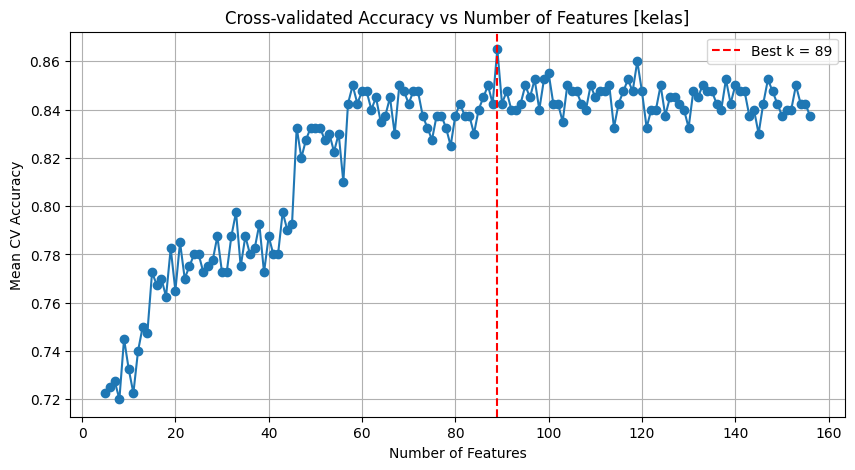

In [13]:

df = pd.read_csv("audio_fitur.csv") 
target = "kelas"
feature_cols = [c for c in df.columns if c not in [target, "filename"]]

X = df[feature_cols].values
y = df[target].values

# Hitung Mutual Information
mi = mutual_info_classif(X, y, discrete_features=False)
mi = np.nan_to_num(mi)
mi_order = np.argsort(mi)[::-1]
sorted_features = [feature_cols[i] for i in mi_order]

# Cross-validated feature selection
score_history = []
for k in range(5, len(sorted_features)+1):
    subset = sorted_features[:k]
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    scores = cross_val_score(clf, df[subset], y, cv=StratifiedKFold(5))
    mean_score = scores.mean()
    score_history.append((k, mean_score))

# Ambil best k dan fitur terpilih
ks = [x[0] for x in score_history]
scores = [x[1] for x in score_history]

best_k, best_score = max(score_history, key=lambda x: x[1])
best_features = sorted_features[:best_k]

print(f"[{target}] Jumlah fitur terpilih: {len(best_features)}")
print(f"[{target}] Fitur terpilih: {best_features}\n")

# Simpan CSV fitur terpilih
df_subset = df[best_features + [target]]
df_subset.to_csv(f"audio_fitur_terpilih_{target}.csv", index=False)

# Plot hasil
plt.figure(figsize=(10, 5))
plt.plot(ks, scores, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title(f'Cross-validated Accuracy vs Number of Features [{target}]')
plt.xlabel('Number of Features')
plt.ylabel('Mean CV Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:


# Load fitur terpilih
df_selected = pd.read_csv(f"audio_fitur_terpilih_{target}.csv")
features = [c for c in df_selected.columns if c != target]

X = df_selected[features].values
y = df_selected[target].values

# Standarisasi sebelum PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)



(400, 21)


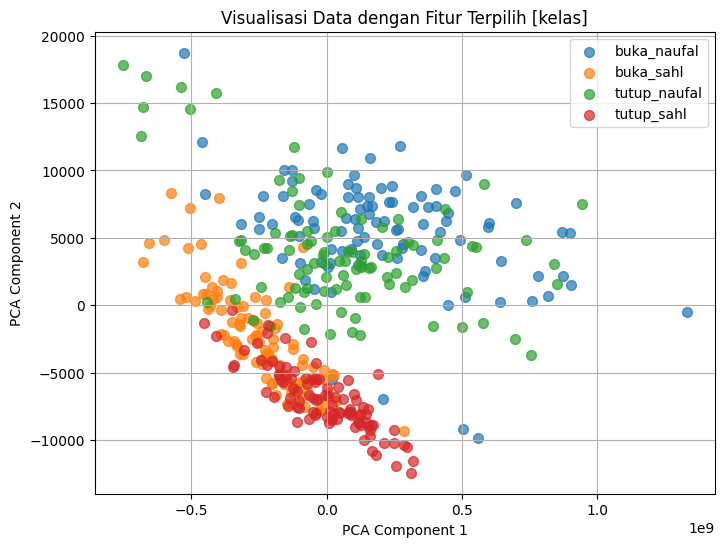

In [23]:


target = "kelas"

# Load fitur terpilih
df_selected = pd.read_csv(f"audio_fitur_terpilih_{target}.csv")
features = [c for c in df_selected.columns if c != target]

X = df_selected[features].values
y = df_selected[target].values

# PCA 2 komponen untuk visualisasi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))

# Loop tiap label untuk scatter plot dengan jitter
for label in np.unique(y):
    idx = y == label
    jitter_x = X_pca[idx, 0] + np.random.normal(0, 0.02, size=np.sum(idx))
    jitter_y = X_pca[idx, 1] + np.random.normal(0, 0.02, size=np.sum(idx))
    plt.scatter(jitter_x, jitter_y, label=label, alpha=0.7, s=50)

plt.title(f'Visualisasi Data dengan Fitur Terpilih [{target}]')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


## **3. Modelling**

### **3.1 Training Model**

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import joblib

target = "kelas"

# Load fitur terpilih
df_selected = pd.read_csv(f"audio_fitur_terpilih_{target}.csv")
features = [c for c in df_selected.columns if c != target]

X = df_selected[features].values
y = df_selected[target].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Standardisasi ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- PCA ---
pca = PCA(n_components=0.95)  # mempertahankan 95% varian
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Dimensi setelah PCA:", X_train_pca.shape)

# --- Random Forest ---
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_pca, y_train)

# Evaluasi
y_pred = rf.predict(X_test_pca)
print(f"=== Evaluasi Random Forest 4 kelas [{target}] ===")
print(f"Akurasi Test: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

# Cross-validation seluruh data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_scaled_full = scaler.fit_transform(X)   # scaling seluruh data
X_pca_full = pca.fit_transform(X_scaled_full)  # PCA seluruh data
scores = cross_val_score(rf, X_pca_full, y, cv=cv)
print(f"CV Mean Accuracy: {scores.mean():.4f}\n")

# Simpan pipeline
joblib.dump(scaler, "scaler.joblib")
joblib.dump(pca, "pca.joblib")
joblib.dump(rf, f"rf_{target}_model.joblib")
pd.DataFrame({"feature": features}).to_csv(f"features_{target}.csv", index=False)


Dimensi setelah PCA: (320, 21)
=== Evaluasi Random Forest 4 kelas [kelas] ===
Akurasi Test: 0.9000
              precision    recall  f1-score   support

 buka_naufal       0.76      0.95      0.84        20
   buka_sahl       0.95      0.95      0.95        20
tutup_naufal       0.94      0.75      0.83        20
  tutup_sahl       1.00      0.95      0.97        20

    accuracy                           0.90        80
   macro avg       0.91      0.90      0.90        80
weighted avg       0.91      0.90      0.90        80

CV Mean Accuracy: 0.8875

